# Power Consumption of Tetouan, Morocco

## Libraries setup and data initialisation

### Installation using pip

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install keras

### Importing libraries

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load datafram from CSV

In [2]:
df  = pd.read_csv("processed-tetuan City power consumption.csv")

In [3]:
ZONES = ['zone_1', 'zone_2' , 'zone_3']

### Set datetime as a index and convert it to DateTime object

In [4]:
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)

## Visualisation of the datasets

### Pairplot to visualize relationships between numerical columns

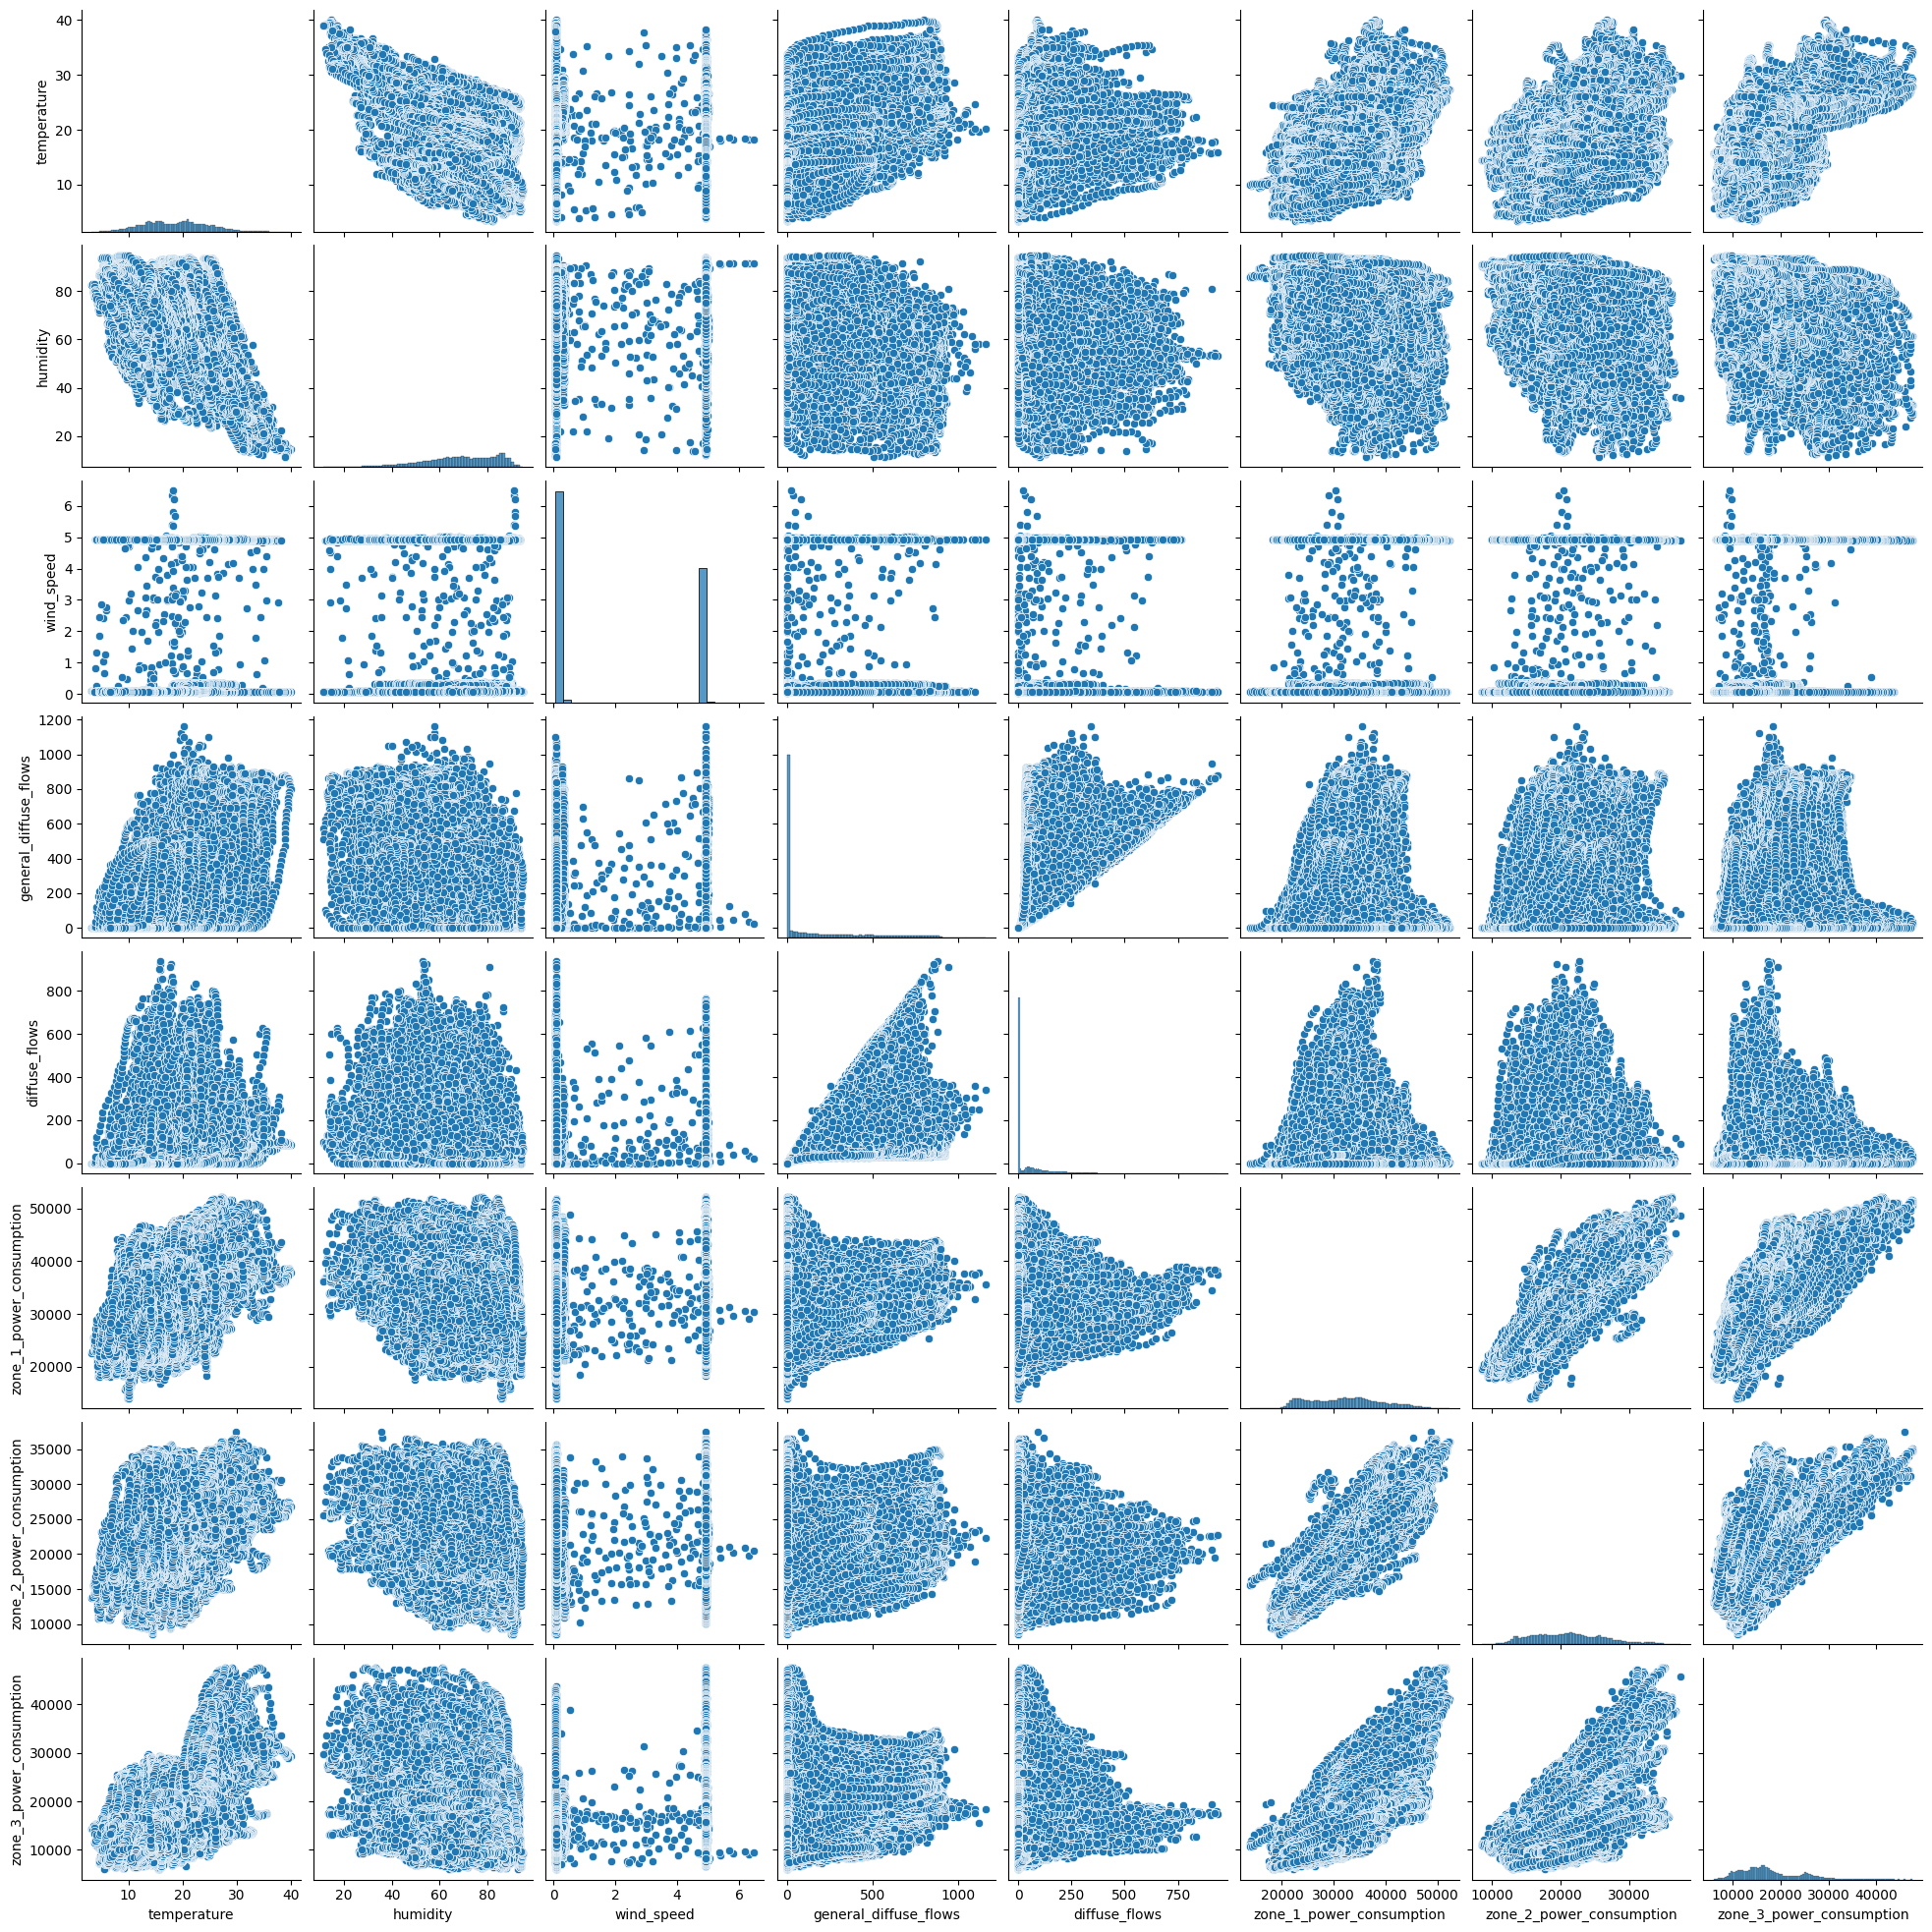

In [5]:
sns.pairplot(df[['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows', 'diffuse_flows','zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption']])
plt.show()

### Ploting training and testing data for each zone

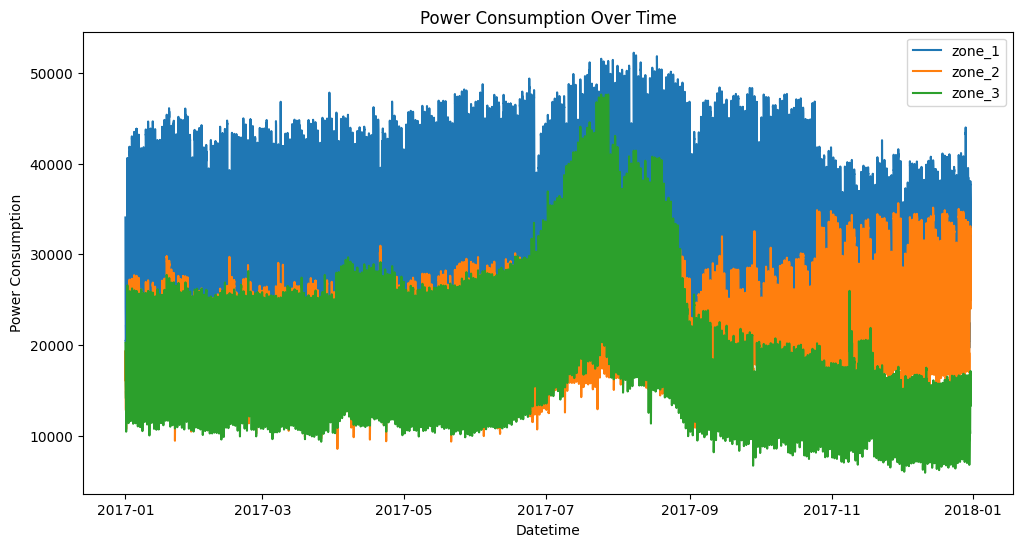

In [6]:
# Time series plot for PowerConsumption
plt.figure(figsize=(12, 6))
for zone in ZONES:
    sns.lineplot(x='datetime', y=f'{zone}_power_consumption', data=df, label=zone)
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

### Plotting each zone power consumption seasion wise using box plotting

Text(0.5, 1.0, 'Boxplot of power consumption by season of the year')

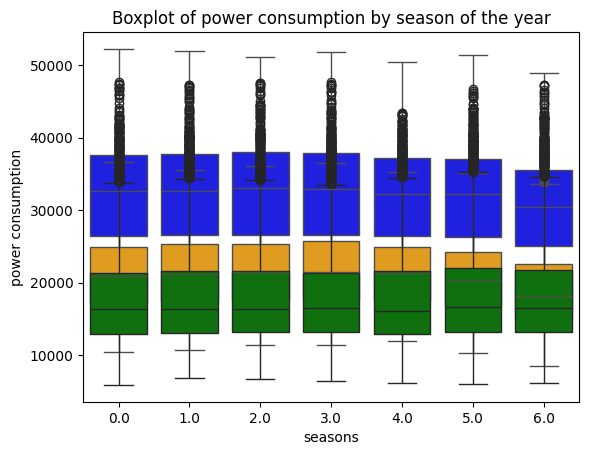

In [7]:
COLORS=['blue', 'orange', 'green']
for zone in ZONES:
    sns.boxplot(data=df, x='dayofweek', y=f'{zone}_power_consumption', color=COLORS[ZONES.index(zone)])
plt.xlabel("seasons")
plt.ylabel("power consumption")
plt.title("Boxplot of power consumption by season of the year")

## EDA using heatmap

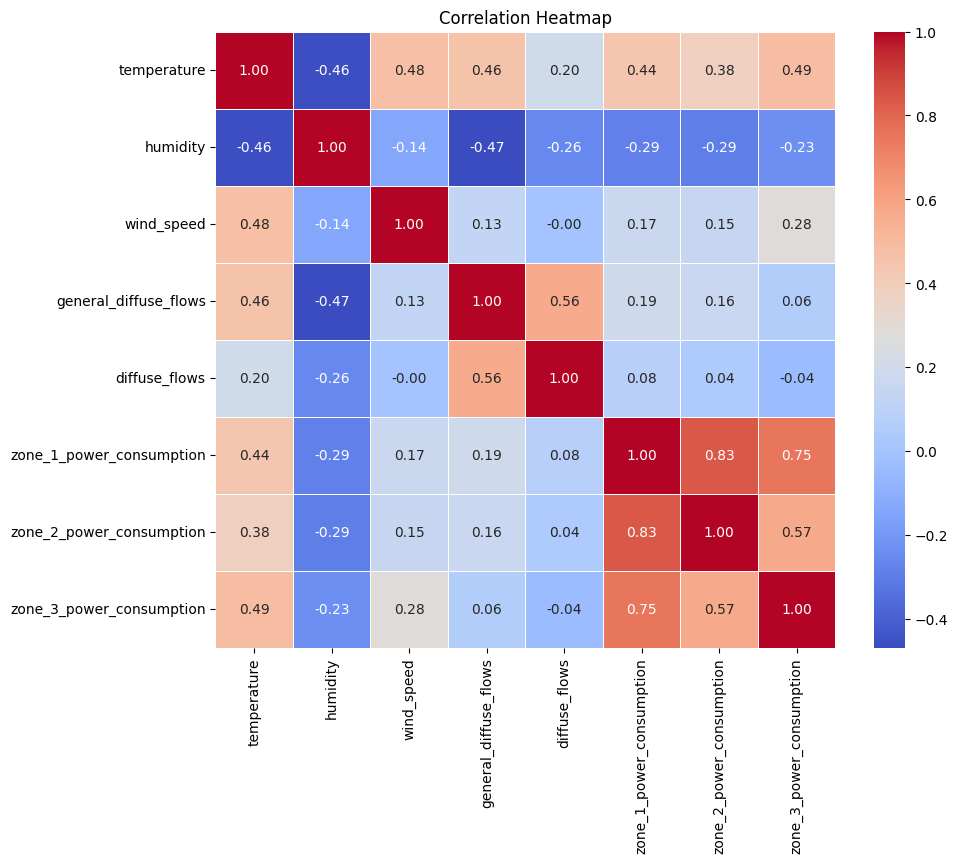

In [27]:
# Calculate correlation matrix
correlation_matrix = df[['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows','diffuse_flows','zone_1_power_consumption', 'zone_2_power_consumption', 'zone_3_power_consumption']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## Modeling

## Seperating trainging data and testing data

### 1st day, 15th day and last days of each month is being considered for testing

In [9]:
df['test_day'] = (df.index.day == 1) | (df.index.day == 15) | (df.index.is_month_end)

In [10]:
train_data = df[~df['test_day']]  # Training data contains all rows where test_day is False
test_data = df[df['test_day']]   # Test data contains all rows where test_day is True

In [11]:
train_data.drop(columns='test_day', inplace=True)
test_data.drop(columns='test_day', inplace=True)

C:\Users\alonj\AppData\Local\Temp\ipykernel_8112\2437088214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns='test_day', inplace=True)
C:\Users\alonj\AppData\Local\Temp\ipykernel_8112\2437088214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns='test_day', inplace=True)


### Seperate features and targets from the trainging and testing data

In [12]:
FEATURES = ['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows',
       'diffuse_flows', 'hour', 'minute', 'dayofweek', 'quarter',
       'month', 'day', 'year', 'season', 'dayofyear', 'dayofmonth',
       'weekofyear']

X_train = train_data[FEATURES]
X_test = test_data[FEATURES]

y_trains = {}
y_tests = {}
for zone in ZONES:
    y_trains[zone] = train_data[f'{zone}_power_consumption']
    y_tests[zone] = test_data[f'{zone}_power_consumption']

### Initialisation of the XGB regression model and training the model using params

In [13]:
models = {}
for zone in ZONES:
    models[zone] = xgb.XGBRegressor(
        n_estimators=20000,
        learning_rate=0.0001,
        early_stopping_rounds = 50,
        eval_metric='mae')
    models[zone].fit(
        X_train, y_trains[zone],
        eval_set=[(X_train, y_trains[zone]),(X_test, y_tests[zone])],
        verbose=2000)

[0]	validation_0-mae:5927.97404	validation_1-mae:5896.57288
[2000]	validation_0-mae:4954.96919	validation_1-mae:4960.73009
[4000]	validation_0-mae:4169.77380	validation_1-mae:4219.01676
[6000]	validation_0-mae:3533.48571	validation_1-mae:3621.44272
[8000]	validation_0-mae:3019.66924	validation_1-mae:3146.77192
[10000]	validation_0-mae:2607.55545	validation_1-mae:2764.36795
[12000]	validation_0-mae:2277.51887	validation_1-mae:2459.83214
[14000]	validation_0-mae:2015.51690	validation_1-mae:2228.96500
[16000]	validation_0-mae:1810.20023	validation_1-mae:2056.16215
[18000]	validation_0-mae:1648.59162	validation_1-mae:1919.54464
[19999]	validation_0-mae:1515.53704	validation_1-mae:1802.93129
[0]	validation_0-mae:4255.65659	validation_1-mae:4200.31518
[2000]	validation_0-mae:3581.96196	validation_1-mae:3558.91832
[4000]	validation_0-mae:3037.00621	validation_1-mae:3051.60499
[6000]	validation_0-mae:2605.97850	validation_1-mae:2648.48757
[8000]	validation_0-mae:2257.95698	validation_1-mae:233

### Calculating mean squared and absolute error

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler_y = StandardScaler()

y_predictions = {}

for zone in ZONES:
    y_predictions[zone] = {}
    y_pred = models[zone].predict(X_test)
    
    # Convert Series to NumPy array and reshape to a 2D array
    y_test_reshaped = y_tests[zone].values.reshape(-1, 1)
    y_pred_reshaped = y_pred.reshape(-1, 1)
    
    # Scale the 2D arrays
    scaled_y_test = scaler_y.fit_transform(y_test_reshaped)
    scaled_y_pred = scaler_y.transform(y_pred_reshaped)
    
    # Calculate MSE and MAE
    y_predictions[zone]['prediction'] = y_pred
    y_predictions[zone]['mse'] = mean_squared_error(scaled_y_test, scaled_y_pred)
    y_predictions[zone]['mae'] = mean_absolute_error(scaled_y_test, scaled_y_pred)
    
    test_data[f'predict_{zone}_power_consumption'] = y_predictions[zone]['prediction']


C:\Users\alonj\AppData\Local\Temp\ipykernel_8112\2260102942.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'predict_{zone}_power_consumption'] = y_predictions[zone]['prediction']
C:\Users\alonj\AppData\Local\Temp\ipykernel_8112\2260102942.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'predict_{zone}_power_consumption'] = y_predictions[zone]['prediction']
C:\Users\alonj\AppData\Local\Temp\ipykernel_8112\2260102942.py:25: SettingWithCopyWarning: 
A value is trying to be set 

### Plotting feature importance

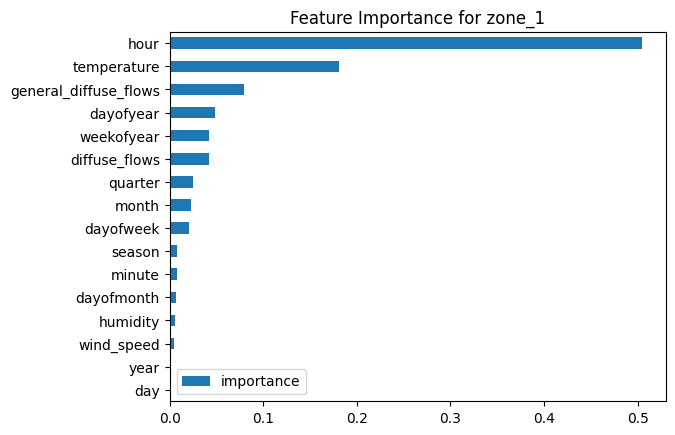

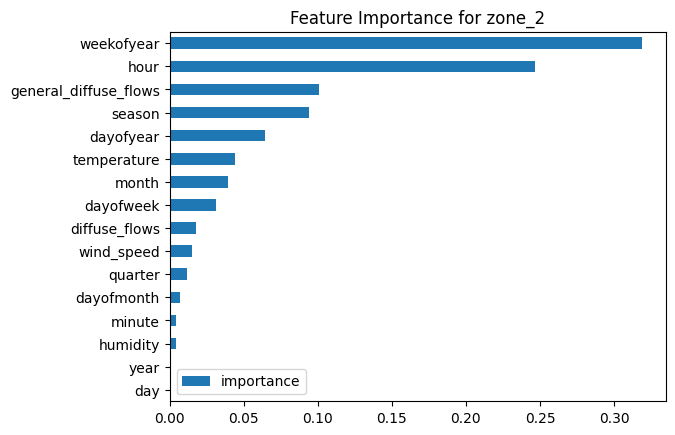

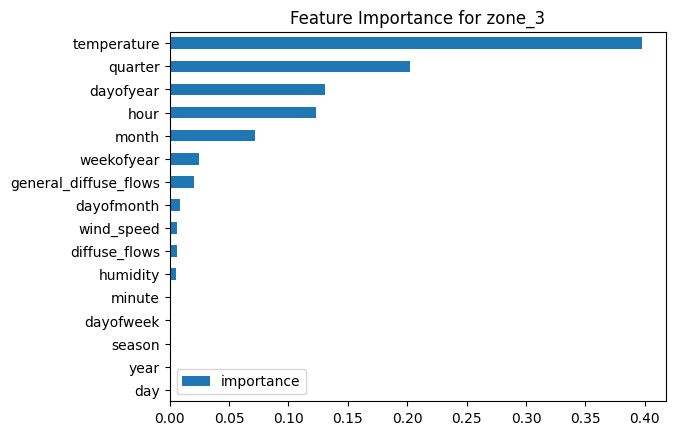

In [15]:
for zone in y_predictions:
    fi = pd.DataFrame(data=models[zone].feature_importances_, index=models[zone].feature_names_in_, columns=['importance'])
    fi.sort_values('importance').plot(kind = 'barh', title=f'Feature Importance for {zone}')
plt.show()

## Calculate accuracy

### Root mean squared error and root mean absoulate error of each model 

In [16]:
for zone in ZONES:
    print(f"{zone}")
    print("mean squared error: ", y_predictions[zone]['mse'])
    print("mean absoluate error: ", y_predictions[zone]['mae'])

zone_1
mean squared error:  0.11567414060426577
mean absoluate error:  0.2526361009563823
zone_2
mean squared error:  0.13625133270773293
mean absoluate error:  0.28252803049395847
zone_3
mean squared error:  0.0638621042010969
mean absoluate error:  0.19704552794838828


### r2_score

In [17]:
from sklearn.metrics import r2_score
for zone in ZONES:
    accuracy = r2_score(y_tests[zone], y_predictions[zone]['prediction'])
    print(f"r2_score metrix for {zone}:", accuracy)


r2_score metrix for zone_1: 0.8843258633358694
r2_score metrix for zone_2: 0.8637486676846216
r2_score metrix for zone_3: 0.9361378993002704


### Comparing predicted result and actual result using graphs

In [18]:
df = df.merge(test_data[['predict_zone_1_power_consumption','predict_zone_2_power_consumption', 'predict_zone_3_power_consumption']], how='left', left_index=True, right_index=True)

Text(0.5, 1.0, 'Prediction check Zone 1')

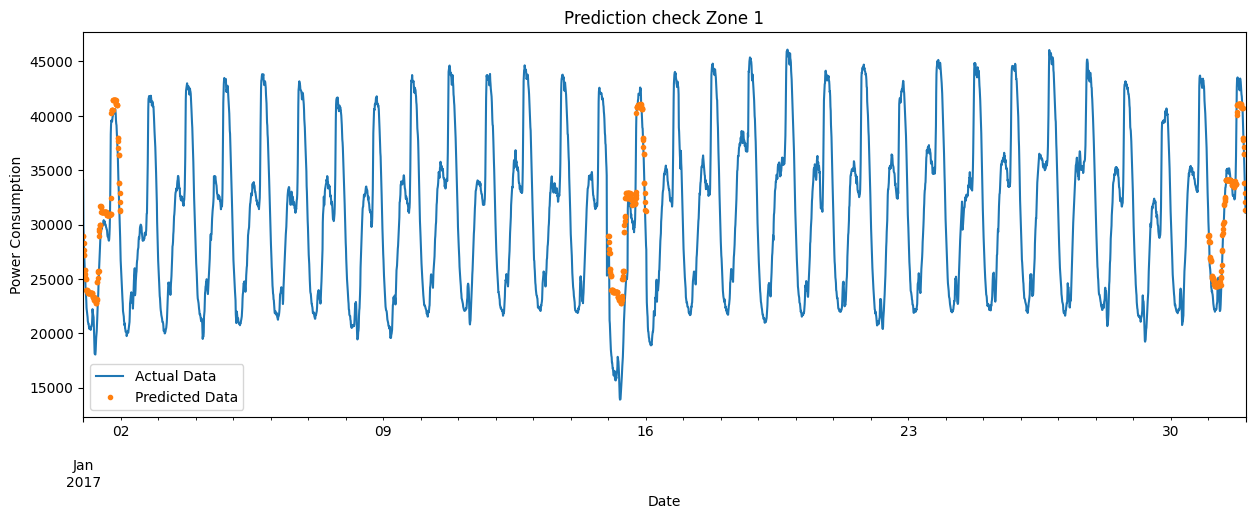

In [24]:
ax = df[df.index < '2017-02-01'][['zone_1_power_consumption']].plot(figsize=(15,5))
df[df.index < '2017-02-01'][['predict_zone_1_power_consumption']].plot(ax=ax, style='.')
ax.set_ylabel('Power Consumption')
ax.set_xlabel('Date')
ax.legend(['Actual Data', 'Predicted Data'])
ax.set_title('Prediction check Zone 1')

Text(0.5, 1.0, 'Prediction check Zone 2')

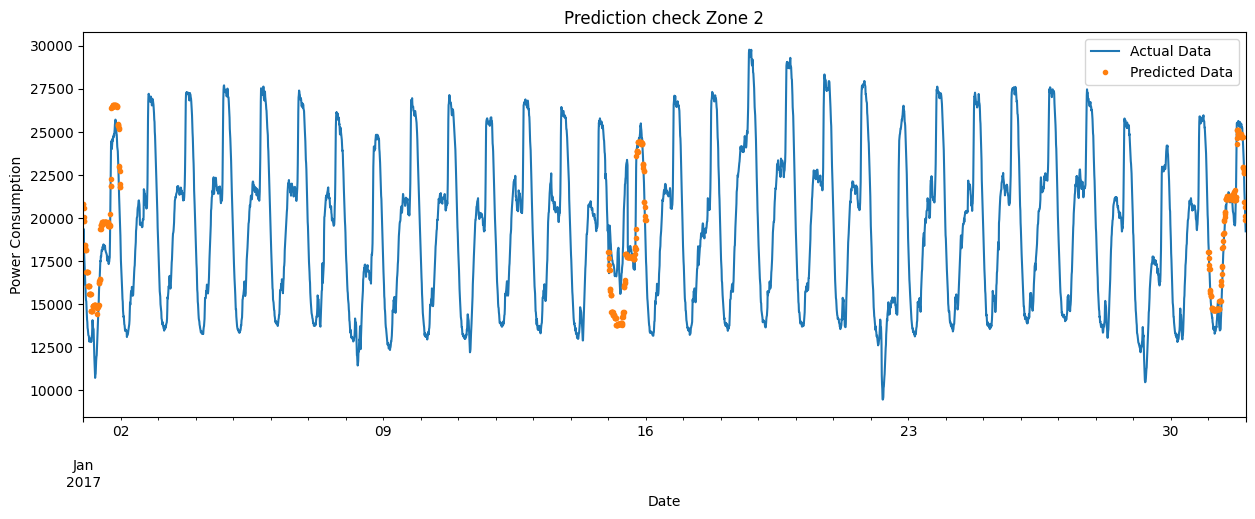

In [25]:
ax = df[df.index < '2017-02-01'][['zone_2_power_consumption']].plot(figsize=(15,5))
df[df.index < '2017-02-01'][['predict_zone_2_power_consumption']].plot(ax=ax, style='.')
ax.set_ylabel('Power Consumption')
ax.set_xlabel('Date')
ax.legend(['Actual Data', 'Predicted Data'])
ax.set_title('Prediction check Zone 2')

Text(0.5, 1.0, 'Prediction check Zone 3')

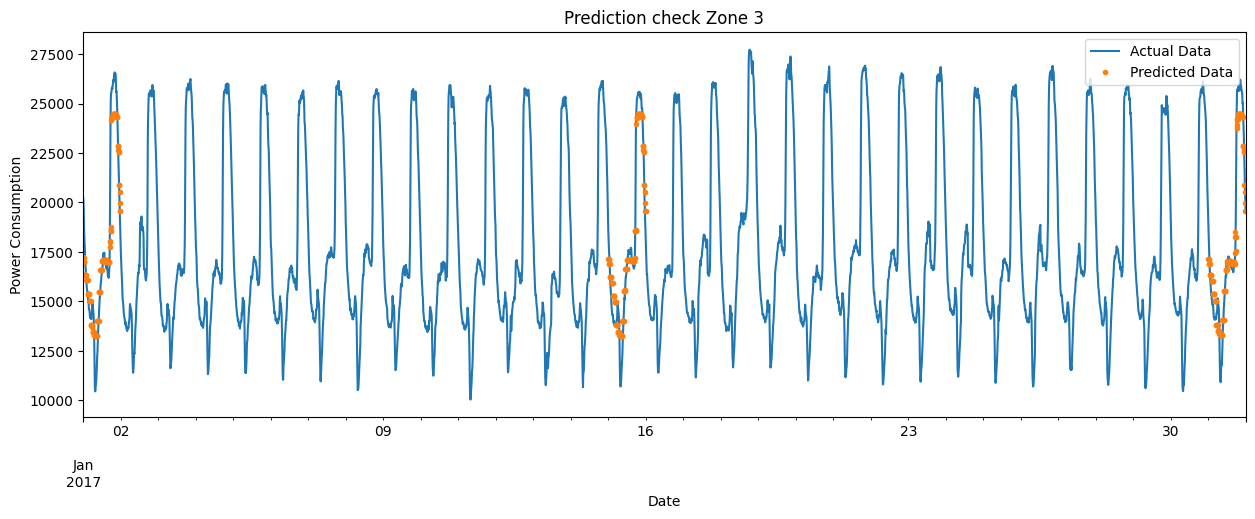

In [26]:
ax = df[df.index < '2017-02-01'][['zone_3_power_consumption']].plot(figsize=(15,5))
df[df.index < '2017-02-01'][['predict_zone_3_power_consumption']].plot(ax=ax, style='.')
ax.set_ylabel('Power Consumption')
ax.set_xlabel('Date')
ax.legend(['Actual Data', 'Predicted Data'])
ax.set_title('Prediction check Zone 3')

## Save the model for application usage using pickle builtin library

### Import pickle

In [22]:
import pickle

### Save the iris classification model as a pickle file

In [23]:
model_pkl_file = "power_consumption_model.pkl"  

for zone in ZONES:
    with open(f'webapp/power_consumption_model_{zone}.pkl', 'wb') as file:
        pickle.dump(models[zone], file)